In [1]:
import pandas as pd
import keras_tuner as kt
import tensorflow as tf
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

In [3]:
X_train_full.shape

(60000, 28, 28)

In [4]:
X_valid, X_train = X_train_full[:5000]/255., X_train_full[5000:]/255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test/255.

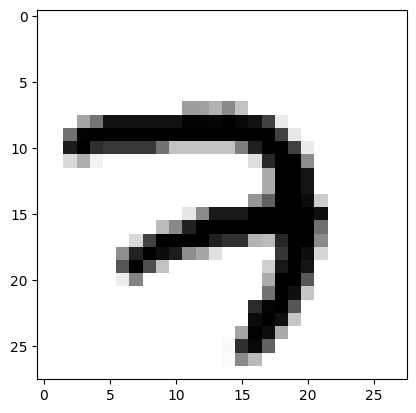

In [7]:
plt.imshow(X_train[0], cmap='binary')
plt.show()

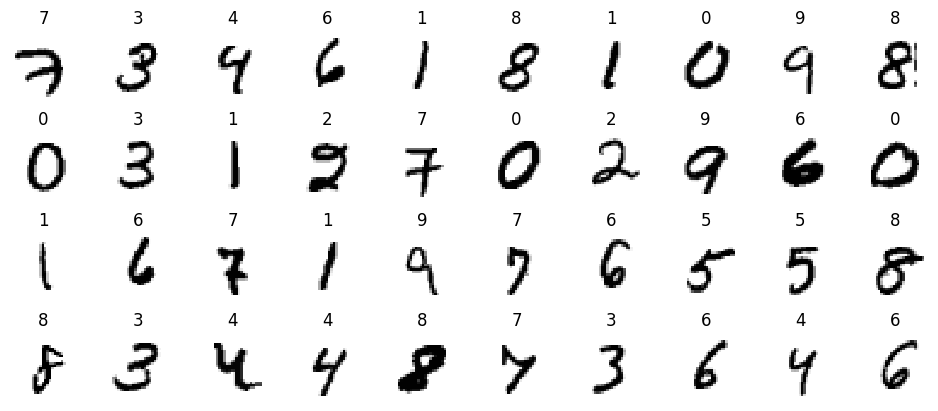

In [57]:
n_rows=4
n_cols=10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index=n_cols * row + col
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(X_train[index], cmap='binary', interpolation='nearest')
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [113]:
# building a callback to grow the learning rate at each iteration

K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
        
    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()*self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs['loss'])

In [114]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [115]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [116]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-1)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics = ['accuracy'])
expon_lr = ExponentialLearningRate(factor=1.005)

In [77]:
history = model.fit(X_train, y_train, epochs=1, validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.5146 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


Text(0, 0.5, 'Loss')

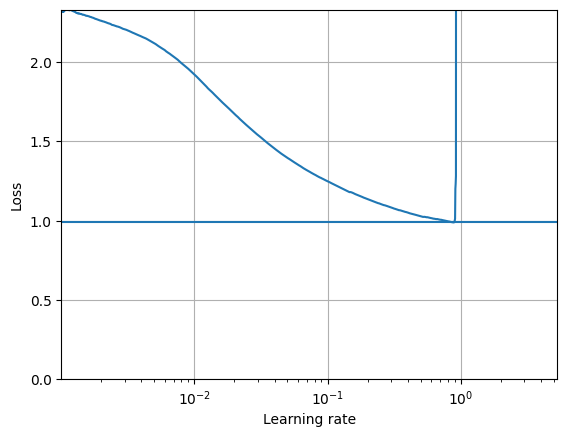

In [78]:
# plotting loss function

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [117]:
run_index = 1 # increment this at every step
run_logdir = Path() / 'my_mnist_logs' / 'run_{:03d}'.format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [118]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('my_mnist_model.keras', save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.8607 - loss: 0.4652 - val_accuracy: 0.9672 - val_loss: 0.1193
Epoch 2/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.9633 - loss: 0.1210 - val_accuracy: 0.9762 - val_loss: 0.0861
Epoch 3/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 635us/step - accuracy: 0.9779 - loss: 0.0763 - val_accuracy: 0.9768 - val_loss: 0.0765
Epoch 4/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 624us/step - accuracy: 0.9858 - loss: 0.0527 - val_accuracy: 0.9788 - val_loss: 0.0769
Epoch 5/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 623us/step - accuracy: 0.9903 - loss: 0.0378 - val_accuracy: 0.9786 - val_loss: 0.0748
Epoch 6/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 622us/step - accuracy: 0.9937 - loss: 0.0267 - val_accuracy: 0.9786 - val_loss: 0.0769
Epoch 7/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.9959 - loss: 0.0186 - val_accuracy: 0.9806 - val_loss: 0.0771
Epoch 8/100
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 1s 621us/step - accuracy: 

In [119]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - accuracy: 0.9731 - loss: 0.0882


[0.07090257853269577, 0.9781000018119812]